# Manifold

author: steeve.laquitaine@epfl.ch  
date: 21.02.1984

* task parameters (see bbp_workflow config):
    * start delay: 1000 ms
    * stimulus delay: 1500 ms
    * 360 stimuli x 50 repeated trials for characterizing the tuning curves
    * interstimulus interval: 200 ms


* data:
    1. 36 simulation files
    2. bbp_workflow config script spikesorting_stim_rotations.py indicates 36 files with orientations for file 1: 0 to 9, file 2: 10 to 19 etc...
    3. png files confirm point 2): /gpfs/bbp.cscs.ch/project/proj83/scratch/home/isbister/post_physiology_2023/sim_data/campaigns/spikesorting_stimulus_tests/4_spikesorting_stimulus_test_neuropixels_8-1-24/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/35
    5. Thus: Each simulation file is organized as: simulation file duration (101500 ms) = start delay of 1500 ms then 10 repeats of (orientation for 9800 ms followed by 200 ms of ISI)

### Requirements

* https://github.com/schung039/neural_manifolds_replicaMFT.git

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.decomposition import PCA # dimensionality reduction
from mftma.manifold_analysis_correlation import manifold_analysis_corr
import random
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config


# EVOKED
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "stimulus"
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["output"]

# SORTINGS

# kilosort 3.0
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# kilosort 2.5
KS2_5_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort2_5"]["output"]

# kilosort 2.0
KS2_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort2"]["output"]

# kilosort
KS_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort"]["output"]

# hdsort (TODO: fix bug gaussmf)
#KS_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort"]["output"]

# herdingspikes
HS_SORTING_PATH = data_conf["sorting"]["sorters"]["herdingspikes"]["output"]

# klusta (TODO: fix bug)

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi":300} 
# print(plt.rcParams.keys())

2024-02-26 15:18:46,221 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-26 15:18:46,297 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [6]:
def get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
):
    # get epoch timings
    epoch_ms = n_simulations * (
        [start_delay] + n_orientations * n_repeats * [stimulus_duration]
    )
    # get epoch labels
    epoch_labels = n_simulations * (
        ["delay"] + n_orientations * n_repeats * ["stimulus"]
    )

    return {"epoch_labels": epoch_labels, "epoch_ms": epoch_ms}


def get_stimulus_intervals_ms(epoch_labels, epoch_ms):

    # find stimulus epoch starts and ends
    epoch_end_ms = np.cumsum(epoch_ms)
    epoch_start_ms = np.hstack([0, epoch_end_ms])[:-1]
    df = pd.DataFrame(data=epoch_end_ms)
    df.columns = ["end"]
    df.insert(0, "start", epoch_start_ms)
    df.index = epoch_labels

    # get stimulus intervals
    return [tuple(df.iloc[ix]) for ix in range(len(df)) if df.index[ix] == "stimulus"]


def get_stimulus_labels():
    start = np.arange(0, 360, 10)
    end = np.arange(10, 370, 10)

    stimulus_labels = []
    for ix in range(36):
        stimulus_labels.append(np.repeat(np.arange(start[ix], end[ix], 1), 50))
    return np.array(stimulus_labels).flatten()


def convert_spike_trains_to_ms(spike_trains: np.array, sfreq: int):
    """_summary_

    Args:
        spike_trains (np.array): _description_
        sfreq (int): _description_

    Returns:
        _type_: _description_
    """
    sample_ms = 1 / (sfreq / 1000)
    spike_trains_ms = spike_trains * sample_ms
    return spike_trains_ms


def get_evoked_responses(spike_trains_ms: np.array, stim_intervals_ms: np.array):
    """_summary_

    Args:
        spike_trains_ms (np.array): _description_
        stim_intervals_ms (np.array): array of tuples (start, end)

    Returns:
        _type_: _description_
    """
    # Use numpy's digitize function to find the bin indices for each value
    bins = [interval[1] for interval in stim_intervals_ms]

    # Return the indices of the bins to which each value in spike_trains_ms belongs.
    bin_indices = np.digitize(spike_trains_ms, bins=bins)

    # Use Counter to count occurrences of bin indices
    interval_counter = Counter(bin_indices)

    # find active stimulus epochs
    active_bin_spike_count = [items[1] for items in list(interval_counter.items())]
    active_bin_ix = [items[0] for items in list(interval_counter.items())]

    # cast unit responses by stimulus epoch in an array
    unit_responses = np.zeros(len(bins))
    unit_responses[active_bin_ix] = active_bin_spike_count
    return unit_responses


def compute_response_by_stim_matrix(unit_ids, SortingTrueKS3, stimulus_intervals_ms):
    """_summary_

    Args:
        SortingTrueKS3 (_type_): _description_
        stimulus_intervals_ms (_type_): _description_

    Returns:
        _type_: _description_
    """
    SFREQ = SortingTrueKS3.get_sampling_frequency()

    # takes 18 secs
    responses = []
    for unit_id in unit_ids:
        spike_trains = SortingTrueKS3.get_unit_spike_train(unit_id)
        spike_trains_ms = convert_spike_trains_to_ms(spike_trains, SFREQ)
        responses.append(get_evoked_responses(spike_trains_ms, stimulus_intervals_ms))
    return np.array(responses)


def plot_manifold_from_pca(responses: np.ndarray, params: dict, ax, axis_lim):
    """PLot manifold

    Args:
      responses (np.ndarray): neurons x stimulus
    """
    # fit pca to neural responses
    pca = PCA(n_components=params["dims"])  # parametrize pca
    manifold = pca.fit_transform(responses.T)  # apply pca
    manifold = manifold / np.max(np.abs(manifold))  # normalise the values

    # setup plot parameters
    DOWNSAMPLE = 10

    # setup plot
    plt.set_cmap("hsv")  # circular cmap

    # 3D projection
    ax.view_init(20, 45, 0)  # elevation, azimuth, roll

    # color the stimulus orientations
    cmap = params["orientations"][::DOWNSAMPLE]

    # plot neural manifold
    scat = ax.scatter(
        manifold[::DOWNSAMPLE, 0],
        manifold[::DOWNSAMPLE, 1],
        manifold[::DOWNSAMPLE, 2],
        c=cmap,
        edgecolors="w",
        linewidths=0.2,
        s=2,
        rasterized=True,  # memory efficiency
    )

    # add legend
    ax.set_xlim(axis_lim)
    ax.set_ylim(axis_lim)
    ax.set_zlim(axis_lim)
    cbar = plt.colorbar(scat, ticks=[0, 90, 180, 270, 359], fraction=0.026, pad=0.04)
    cbar.ax.set_ylabel("Stimulus orientations (deg)", rotation=270, labelpad=7)
    cbar.ax.set_yticklabels([0, 90, 180, 270, 359])
    ax.set_xlabel("Neural latent 1")
    ax.set_ylabel("Neural latent 2")
    ax.set_zlabel("Neural latent 3")
    ax.set_xticks([-0.5, 0, 0.5, 1])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_zticks([-0.5, 0, 0.5, 1])
    ax.set_xticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.set_yticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.set_zticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.tick_params(axis="x", which="major", pad=-3)
    ax.tick_params(axis="y", which="major", pad=-3)
    ax.tick_params(axis="z", which="major", pad=-3)
    ax.set_xlabel("Neural latent 1", labelpad=-10)
    ax.set_ylabel("Neural latent 2", labelpad=-10)
    ax.set_zlabel("Neural latent 3", labelpad=-5)
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_box_aspect((1, 1, 1))
    print("manifold axis max:", max(manifold.max(axis=1)))
    print("manifold axis min:", min(manifold.min(axis=1)))
    return {"manifold": manifold, "ax": ax}


def plot_manifold_dims_1_2(manifold: dict, params, ax, axis_lim):

    # downsample manifold for speed
    # and memory efficiency
    DOWNSAMPLE = 10

    # color the stimulus orientations
    cmap = params["orientations"][::DOWNSAMPLE]

    # plot neural manifold
    scat = ax.scatter(
        manifold["manifold"][::DOWNSAMPLE, 0],
        manifold["manifold"][::DOWNSAMPLE, 1],
        c=cmap,
        edgecolors="w",
        linewidths=0.2,
        rasterized=True,  # memory efficiency
    )

    # add legend
    ax.set_xlim(axis_lim)
    ax.set_ylim(axis_lim)
    ax.set_xticklabels([-0.5, 0, 0.5, 1])
    ax.set_yticklabels([-0.5, 0, 0.5, 1])
    ax.set_xticks([-0.5, 0, 0.5, 1])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    # cbar = plt.colorbar(scat, ticks=[0, 90, 180, 270, 359], fraction=0.026, pad=0.04)
    # cbar.ax.set_ylabel("Stimulus orientations (deg)", rotation=270, labelpad=7)
    # cbar.ax.set_yticklabels([0, 90, 180, 270, 359])

    # legend
    ax.set_xlabel("Neural latent 1")
    ax.set_ylabel("Neural latent 2")
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_box_aspect((1))
    return ax


def reshape_responses(responses: np.array, stimulus_labels, n_exple_per_class: int):
    """format unit responses into a list of N_CLASSES arrays of
    size N units x N_EXPLE_PER_CLASS

    Returns:
        (list[arrays]): _description_
    - e.g., dataset = [np.random.randn(5000, 50) for i in range(100)]
    """
    dataset = [
        responses[:, stimulus_labels == orientation]
        for orientation in np.unique(stimulus_labels)
    ]
    assert dataset[1].shape[1] == n_exple_per_class, "wrong shape"
    return dataset


def plot_all_sorted_unit_manifolds(
    Sorting, stimulus_intervals_ms, params, params_pca, save, filename, axis_lim
):
    """plot manifolds for Kilosort and Herdingspikes
    They do not have a postprocessing operation that curates
    single units. They yield all the sorted units found.

    Args:
        Sorting (_type_): _description_
        stimulus_intervals_ms (_type_): _description_
        params (_type_): _description_
        params_pca (_type_): _description_
        save (_type_): _description_
        filename (_type_): _description_

    Returns:
        _type_: _description_
    """
    FIG_SIZE = (2.8, 2.8)

    # compute response matrix (unit x stimulus)
    responses_all_sorted = compute_response_by_stim_matrix(
        Sorting.unit_ids, Sorting, stimulus_intervals_ms
    )

    # plot
    fig = plt.figure(figsize=FIG_SIZE)

    # plot 3D manifold
    ax = fig.add_subplot(2, 1, 1, projection="3d")
    manifold_sorted = plot_manifold_from_pca(
        responses_all_sorted, params_pca, ax, axis_lim
    )

    # project onto neural latents 1 and 2
    ax = fig.add_subplot(2, 1, 2)
    ax = plot_manifold_dims_1_2(manifold_sorted, params, ax, axis_lim)

    fig.subplots_adjust(wspace=0.25, hspace=0.2)

    # save
    if save:
        plt.savefig(
            filename,
            **savefig_cfg,
        )
    return (
        responses_all_sorted,
        Sorting.unit_ids,
    )


def plot_sorted_manifolds(
    Sorting, stimulus_intervals_ms, params, params_pca, save, filename, axis_lim
):
    # Sorted single units ------
    FIG_SIZE = (2.8, 2.8)

    # compute response matrix (unit x stimulus)
    sorted_single_unit_ids = Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"]
    responses_sorted = compute_response_by_stim_matrix(
        sorted_single_unit_ids, Sorting, stimulus_intervals_ms
    )

    # plot
    fig = plt.figure(figsize=FIG_SIZE)

    # plot 3D manifold
    ax = fig.add_subplot(2, 2, 1, projection="3d")
    manifold_sorted = plot_manifold_from_pca(responses_sorted, params_pca, ax, axis_lim)

    # project onto neural latents 1 and 2
    ax = fig.add_subplot(2, 2, 3)
    ax = plot_manifold_dims_1_2(manifold_sorted, params, ax, axis_lim)

    # All sorted ------

    # compute response matrix (unit x stimulus)
    responses_all_sorted = compute_response_by_stim_matrix(
        Sorting.unit_ids, Sorting, stimulus_intervals_ms
    )

    # plot 3D manifold
    ax = fig.add_subplot(2, 2, 2, projection="3d")
    manifold_sorted = plot_manifold_from_pca(
        responses_all_sorted, params_pca, ax, axis_lim
    )

    # project onto neural latents 1 and 2
    ax = fig.add_subplot(2, 2, 4)
    ax = plot_manifold_dims_1_2(manifold_sorted, params, ax, axis_lim)

    # fig.subplots_adjust(wspace=1, hspace=1)
    # tidy up
    fig.subplots_adjust(wspace=0.25, hspace=0.2)

    # save
    if save:
        plt.savefig(
            filename,
            **savefig_cfg,
        )
    return (
        responses_sorted,
        responses_all_sorted,
        sorted_single_unit_ids,
        Sorting.unit_ids,
    )


def analyse_class_manifolds(responses, stimulus_labels, n_exple_per_class, n_new):

    # takes 33m secs (for 20 classes)
    np.random.seed(0)
    kappa = 0  # margin
    n_t = 200

    # reshape responses
    reshaped_responses = reshape_responses(
        responses, stimulus_labels, n_exple_per_class
    )

    # Gaussian Random projection to reduce the dimensionality to the dimensionality of the unit
    # population with the lowest dimensionality (400)
    # that saves time and normalizes the datasets, as they have different number of units.
    # This step should bit change the geometry too much (see the Johnson–Lindenstrauss lemma).
    projected_responses = []

    # reduce dimensionality of each class manifol
    for data in reshaped_responses:
        N = data.shape[0]
        M = np.random.randn(n_new, N)
        M /= np.sqrt(np.sum(M * M, axis=1, keepdims=True))
        X = np.matmul(M, data)
        projected_responses.append(X)

    # analyse manifold geometry
    capacities, radii, dimensions, corr, K = manifold_analysis_corr(
        projected_responses, kappa, n_t
    )
    return {
        "metrics_per_class": {
            "capacity": capacities,
            "radius": radii,
            "dimension": dimensions,
            "correlation": corr,
            "K": K,
        },
        "average_metrics": {
            "capacity": 1 / np.mean(1 / capacities),
            "radius": np.mean(radii),
            "dimensions": np.mean(dimensions),
        },
    }


def get_true_infogeometry(
    responses,
    stimulus_labels,
    sample_classes,
    n_exple_per_class,
    n_new,
    seed=0,
):
    """_summary_
    Takes 6 min for 20 classes with 50 sample per class

    Returns:
        tuple: _description_
    """
    # set seed for reproducibility
    np.random.seed(seed)

    # find actual labels indices
    classes_ix = np.array(
        [
            np.where(stimulus_labels == ix)[0].tolist()
            for ix in sample_classes
            if any(stimulus_labels == ix)
        ]
    ).flatten()

    # find shuffled labels indices to calculate
    # lower bound
    shuffled_labels = np.array(
        random.sample(
            stimulus_labels.tolist(),
            len(stimulus_labels),
        )
    )

    # find classes indices
    shuffle_classes_ix = np.array(
        [
            np.where(shuffled_labels == ix)[0].tolist()
            for ix in sample_classes
            if any(shuffled_labels == ix)
        ]
    ).flatten()

    # analyse manifold information geometry
    out_true = analyse_class_manifolds(
        responses[:, classes_ix], stimulus_labels[classes_ix], n_exple_per_class, n_new
    )

    # get lower bound from unstructured manifolds (to normalize capacity)
    out_true_unstructured = analyse_class_manifolds(
        responses[:, shuffle_classes_ix],
        shuffled_labels[shuffle_classes_ix],
        n_exple_per_class,
        n_new,
    )
    return {
        "true_units": [out_true, out_true_unstructured],
    }


def get_infogeometry_for_sorter(
    responses_sorted,
    responses_all_sorted,
    stimulus_labels,
    sample_classes,
    n_exple_per_class,
    n_new,
    seed=0,
):
    """_summary_
    Takes 6 min for 20 classes with 50 sample per class

    Returns:
        tuple: _description_
    """
    # set seed for reproducibility
    np.random.seed(seed)

    # find actual labels indices
    classes_ix = np.array(
        [
            np.where(stimulus_labels == ix)[0].tolist()
            for ix in sample_classes
            if any(stimulus_labels == ix)
        ]
    ).flatten()

    # find shuffled labels indices to calculate
    # lower bound
    shuffled_labels = np.array(
        random.sample(
            stimulus_labels.tolist(),
            len(stimulus_labels),
        )
    )

    # find classes indices
    shuffle_classes_ix = np.array(
        [
            np.where(shuffled_labels == ix)[0].tolist()
            for ix in sample_classes
            if any(shuffled_labels == ix)
        ]
    ).flatten()

    # Sorted single units ------

    # analyse manifold information geometry
    out_sorted = analyse_class_manifolds(
        responses_sorted[:, classes_ix],
        stimulus_labels[classes_ix],
        n_exple_per_class,
        n_new,
    )

    # get lower bound from unstructed manifolds (to normalize capacity)
    out_sorted_unstructured = analyse_class_manifolds(
        responses_sorted[:, shuffle_classes_ix],
        shuffled_labels[shuffle_classes_ix],
        n_exple_per_class,
        n_new,
    )

    # All sorted units ------

    # analyse manifold information geometry
    out_allsorted = analyse_class_manifolds(
        responses_all_sorted[:, classes_ix],
        stimulus_labels[classes_ix],
        n_exple_per_class,
        n_new,
    )

    # get lower bound from unstructed manifolds (to normalize capacity)
    out_allsorted_unstructured = analyse_class_manifolds(
        responses_all_sorted[:, shuffle_classes_ix],
        shuffled_labels[shuffle_classes_ix],
        n_exple_per_class,
        n_new,
    )
    return {
        "sorted_single_unit": [out_sorted, out_sorted_unstructured],
        "all_sorted_units": [out_allsorted, out_allsorted_unstructured],
    }


def get_infogeometry_for_HS_and_KS(
    responses_all_sorted,
    stimulus_labels,
    sample_classes,
    n_exple_per_class,
    n_new,
    seed=0,
):
    """_summary_
    Takes 6 min for 20 classes with 50 sample per class

    Returns:
        tuple: _description_
    """
    # set seed for reproducibility
    np.random.seed(seed)

    # find actual labels indices
    classes_ix = np.array(
        [
            np.where(stimulus_labels == ix)[0].tolist()
            for ix in sample_classes
            if any(stimulus_labels == ix)
        ]
    ).flatten()

    # find shuffled labels indices to calculate
    # lower bound
    shuffled_labels = np.array(
        random.sample(
            stimulus_labels.tolist(),
            len(stimulus_labels),
        )
    )

    # find classes indices
    shuffle_classes_ix = np.array(
        [
            np.where(shuffled_labels == ix)[0].tolist()
            for ix in sample_classes
            if any(shuffled_labels == ix)
        ]
    ).flatten()

    # analyse manifold information geometry
    out_allsorted = analyse_class_manifolds(
        responses_all_sorted[:, classes_ix],
        stimulus_labels[classes_ix],
        n_exple_per_class,
        n_new,
    )

    # get lower bound from unstructed manifolds (to normalize capacity)
    out_allsorted_unstructured = analyse_class_manifolds(
        responses_all_sorted[:, shuffle_classes_ix],
        shuffled_labels[shuffle_classes_ix],
        n_exple_per_class,
        n_new,
    )
    return {
        "all_sorted_units": [out_allsorted, out_allsorted_unstructured],
    }

### Load datasets

In [3]:
# get true evoked ata
SortingTrue = si.load_extractor(GT_SORTING_PATH)
Recording = si.load_extractor(RECORDING_PATH)
duration_secs = Recording.get_total_duration()
SFREQ = SortingTrue.get_sampling_frequency()
print(SortingTrue.unit_ids)

# get sorted evoked data
SortingKS3 = si.load_extractor(KS3_SORTING_PATH)
print(SortingKS3.unit_ids)

# KS2.5
SortingKS2_5 = si.load_extractor(KS2_5_SORTING_PATH)

# KS
SortingKS = si.load_extractor(KS_SORTING_PATH)

# HS
SortingHS = si.load_extractor(HS_SORTING_PATH)

[  12165   15894   16652 ... 4228700 4229218 4229506]
[   0    1    2 ... 2620 2621 2622]


### Sanity check task params

In [4]:
# sanity check durations and task design

# recording duration
print("recording duration (secs):", duration_secs)

# reconstructed duration from task parameters
# each file contains one stimulus orientation
# 1 - (each simulation file duration (ms) - first 1000 ms that was dropped) * 36 orientation stim / 1000 ms
reconstructed_duration = (101500 - 1000) * 36 / 1000
print("recording duration (secs):", reconstructed_duration)

# Each raw simulation file is organized as: simulation file duration (101500) = start delay of 1500 ms - 10 orientations (0 repeated 50 times for 200 ms without resting period
# then 1 repeated 50 times and so on )
# - file 1: orientation 0 to 9
# - file 2: orientation 10 to 19 etc..
raw_sim_ms = 1500 + 10 * 50 * 200
print("Raw simulation file duration (ms):", raw_sim_ms)

# Each raw simulation file is organized as: simulation file duration (101500) = start delay of 500 ms - 10 orientations (0 repeated 50 times for 200 ms without resting period
# then 1 repeated 50 times and so on )
# - file 1: orientation 0 to 9
# - file 2: orientation 10 to 19 etc..
curated_sim_ms = 500 + 10 * 50 * 200
print("Curated simulation file duration (ms):", curated_sim_ms)

recording duration (secs): 3617.9982
recording duration (secs): 3618.0
Raw simulation file duration (ms): 101500
Curated simulation file duration (ms): 100500


### Get task params

In [5]:
# get task epoch infos
task = get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
)

# get stimulus labeles
stimulus_labels = get_stimulus_labels()

# get stimulus orientation labels
stimulus_intervals_ms = get_stimulus_intervals_ms(
    task["epoch_labels"], task["epoch_ms"]
)

print("orientations:", stimulus_intervals_ms)

orientations: [(500, 700), (700, 900), (900, 1100), (1100, 1300), (1300, 1500), (1500, 1700), (1700, 1900), (1900, 2100), (2100, 2300), (2300, 2500), (2500, 2700), (2700, 2900), (2900, 3100), (3100, 3300), (3300, 3500), (3500, 3700), (3700, 3900), (3900, 4100), (4100, 4300), (4300, 4500), (4500, 4700), (4700, 4900), (4900, 5100), (5100, 5300), (5300, 5500), (5500, 5700), (5700, 5900), (5900, 6100), (6100, 6300), (6300, 6500), (6500, 6700), (6700, 6900), (6900, 7100), (7100, 7300), (7300, 7500), (7500, 7700), (7700, 7900), (7900, 8100), (8100, 8300), (8300, 8500), (8500, 8700), (8700, 8900), (8900, 9100), (9100, 9300), (9300, 9500), (9500, 9700), (9700, 9900), (9900, 10100), (10100, 10300), (10300, 10500), (10500, 10700), (10700, 10900), (10900, 11100), (11100, 11300), (11300, 11500), (11500, 11700), (11700, 11900), (11900, 12100), (12100, 12300), (12300, 12500), (12500, 12700), (12700, 12900), (12900, 13100), (13100, 13300), (13300, 13500), (13500, 13700), (13700, 13900), (13900, 14100

### Compare manifolds

#### (20s) True manifold

* all 360 orientation classes are represented

In [7]:
# takes 20 secs

FIG_SIZE = (2.8, 2.8)

# set parameters
params = {"orientations": stimulus_labels}
params_pca = {
    "dims": 3,  # dimensions
    "orientations": params["orientations"],  # stimulus orientations
}

# compute unit x stimulus response matrix
responses = compute_response_by_stim_matrix(
    SortingTrue.unit_ids, SortingTrue, stimulus_intervals_ms
)

# plot
fig = plt.figure(figsize=FIG_SIZE)

# 3D-manifold
ax = fig.add_subplot(2, 1, 1, projection="3d")
manifold = plot_manifold_from_pca(responses, params_pca, ax, axis_lim=[-0.6, 1.1])

# 2D-projected manifold
ax = fig.add_subplot(2, 1, 2)
ax = plot_manifold_dims_1_2(manifold, params, ax, axis_lim=[-0.6, 1.1])

# tidy up
fig.subplots_adjust(wspace=0.1, hspace=0.2)

# save figure
plt.savefig(
    PROJ_PATH + "/figures/4_neural_code/svg/cbar_for_manifold_true.svg", **savefig_cfg
)

manifold axis max: 1.0
manifold axis min: -0.5180597493924708


In [146]:
# takes 20 secs

FIG_SIZE = (2.8, 2.8)

# set parameters
params = {"orientations": stimulus_labels}
params_pca = {
    "dims": 3,  # dimensions
    "orientations": params["orientations"],  # stimulus orientations
}

# compute unit x stimulus response matrix
responses = compute_response_by_stim_matrix(
    SortingTrue.unit_ids, SortingTrue, stimulus_intervals_ms
)

# plot
fig = plt.figure(figsize=FIG_SIZE)

# 3D-manifold
ax = fig.add_subplot(2, 1, 1, projection="3d")
manifold = plot_manifold_from_pca(responses, params_pca, ax, axis_lim=[-0.6, 1.1])

# 2D-projected manifold
ax = fig.add_subplot(2, 1, 2)
ax = plot_manifold_dims_1_2(manifold, params, ax, axis_lim=[-0.6, 1.1])

# tidy up
fig.subplots_adjust(wspace=0.1, hspace=0.2)

# save figure
plt.savefig(PROJ_PATH + "/figures/4_neural_code/svg/manifold_true.svg", **savefig_cfg)

#### (28s) KS3-sorted manifolds

* all 360 orientation classes are represented

manifold axis max: 1.0
manifold axis min: -0.48635155449362005
manifold axis max: 1.0
manifold axis min: -0.2617712065630637


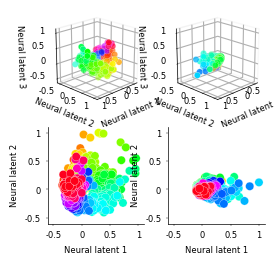

In [50]:
(
    responses_sorted_ks3,
    responses_all_sorted_ks3,
    sorted_single_unit_ids_ks3,
    all_unit_ids_ks3,
) = plot_sorted_manifolds(
    SortingKS3,
    stimulus_intervals_ms,
    params,
    params_pca,
    save=True,
    filename=PROJ_PATH + "/figures/4_neural_code/svg/manifold_ks3.svg",
    axis_lim=[-0.6, 1.1],
)

#### KS2.5 sorted manifolds

* all 360 orientation classes are represented

manifold axis max: 1.0
manifold axis min: -0.4542842457216593
manifold axis max: 1.0
manifold axis min: -0.18508193581223967


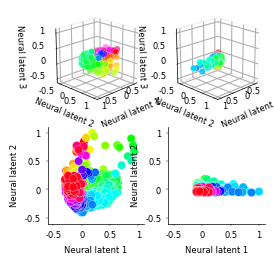

In [51]:
# takes 20 secs
(
    responses_sorted_ks2_5,
    responses_all_sorted_ks2_5,
    sorted_single_unit_ids_ks2_5,
    all_unit_ids_ks2_5,
) = plot_sorted_manifolds(
    SortingKS2_5,
    stimulus_intervals_ms,
    params,
    params_pca,
    save=True,
    filename="/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/4_neural_code/svg/manifold_ks2_5.svg",
    axis_lim=[-0.6, 1.1],
)

#### KS-sorted manifolds

* KS does not have a postprocessing operation that curates single units and yield all found units.

manifold axis max: 1.0
manifold axis min: -0.24252811708280916


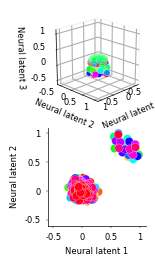

In [58]:
# takes 20 secs
(
    responses_all_sorted_ks,
    all_unit_ids_ks,
) = plot_all_sorted_unit_manifolds(
    SortingKS,
    stimulus_intervals_ms,
    params,
    params_pca,
    save=True,
    filename="/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/4_neural_code/svg/manifold_ks.svg",
    axis_lim=[-0.6, 1.1],
)

#### HS-sorted manifolds

* HS does not have a postprocessing operation that curates single units and yield all found units.

manifold axis max: 1.0
manifold axis min: -0.4558151276727005


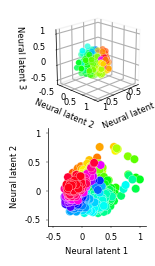

In [59]:
# takes 20 secs
(
    responses_all_sorted_hs,
    all_unit_ids_hs,
) = plot_all_sorted_unit_manifolds(
    SortingHS,
    stimulus_intervals_ms,
    params,
    params_pca,
    save=True,
    filename="/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/4_neural_code/svg/manifold_hs.svg",
    axis_lim=[-0.6, 1.1],
)

### Compare True and sorted manifold information contents

* **Class manifold**: 
    * "The set of all state vectors corresponding to responses to all possible stimuli associated with the same object can be viewed as a manifold in the neural state space” [Chung et al., 2017]
* The **load**: 
    * of the neural population is alpha = P/N.
* The **manifold capacity**:
    * is the critical load: alpha_c. It is the critical number of object manifolds, P, that can be linearly separated (by a linear hyperplane through the origin [Chung et al., 2017]) given N features. It is the linearly decodable information about object per unit. 
    * It captures the linear separability of object manifolds. 
    * If the load alpha=P/N is below the manifold capacity alpha_c, most object manifold are separable, else most are inseparable.
    * **lower bound**: “The manifold capacity for point-cloud manifolds is lower bounded by the case where there is no manifold structure.” [Stephenson et al., 2020]
* The **manifold dimension**:
    * upper bound is min(M,N) where M is the number of points per manifold (50 sample instances in our case) and N is the number of units.

* The **Margin**: 
    * “The robustness of a linear classifier is quantified by the margin, which measures the distance between the separating hyperplane and the closest point.” [Chung et al., 2017]

Method:
* the unit populations have different unit sizes, so the manifold capacity must be normalized.

In [15]:
# takes 1 sec

N_NEW = 200  # number of new neural latents resulting from Gaussian random projection

# set parameters
sample_classes = np.arange(0, 360, 18)  # sample 20 classes (360 is too costly)

# number of sample instances per class
n_exple_per_class = sum(params["orientations"] == 0)

print("classes (count):", len(sample_classes))
print("unit (count):", responses.shape[0])
print("load:", len(sample_classes) / responses.shape[0])

classes (count): 20
unit (count): 1836
load: 0.010893246187363835


#### True manifold

In [16]:
out_true = get_true_infogeometry(
    responses,
    stimulus_labels,
    sample_classes,
    n_exple_per_class,
    n_new=N_NEW,
    seed=0,
)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +1.2078159238260740e+01    3.46186522e-01    
   2         +1.1965220438106773e+01    2.17593896e-01    
   3         +1.1902842787786430e+01    1.82428473e-01    
   4         +1.1859028667791078e+01    1.33258896e-01    
   5         +1.1836692128341600e+01    1.06461816e-01    
   6         +1.1811530398249147e+01    8.10551429e-02    
   7         +1.1804782453410922e+01    6.84971974e-02    
   8         +1.1798711079411200e+01    5.50024962e-02    
   9         +1.1794640911498846e+01    4.16738187e-02    
  10         +1.1792316100305744e+01    3.47504303e-02    
  11         +1.1790871993600540e+01    3.45317281e-02    
  12         +1.1790223367657152e+01    1.39822077e-02    
  13         +1.1790051368198682e+01    1.21870242e-02    
  14         +1.1789978543107742e+01    7.34412578e-03    
  15         +1.1789923464126069e+01    6.

### (12m) Sorted manifold info-metrics by sorter and quality

In [18]:
# takes 10 min for 20 classes (50 sample per class)

# KS 3.0
out_ks3 = get_infogeometry_for_sorter(
    responses_sorted_ks3,
    responses_all_sorted_ks3,
    stimulus_labels,
    sample_classes,
    n_exple_per_class,
    N_NEW,
    seed=0,
)

# KS 2.5
out_ks2_5 = get_infogeometry_for_sorter(
    responses_sorted_ks2_5,
    responses_all_sorted_ks2_5,
    stimulus_labels,
    sample_classes,
    n_exple_per_class,
    N_NEW,
    seed=0,
)

# KS
out_ks = get_infogeometry_for_HS_and_KS(
    responses_all_sorted_ks,
    stimulus_labels,
    sample_classes,
    n_exple_per_class,
    N_NEW,
    seed=0,
)

# HS
out_hs = get_infogeometry_for_HS_and_KS(
    responses_all_sorted_hs,
    stimulus_labels,
    sample_classes,
    n_exple_per_class,
    N_NEW,
    seed=0,
)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +1.2149415615091039e+01    4.14379884e-01    
   2         +1.1994201498391071e+01    2.75108797e-01    
   3         +1.1922887011669818e+01    2.05232545e-01    
   4         +1.1881346850066526e+01    1.42377099e-01    
   5         +1.1861100883069405e+01    1.07411660e-01    
   6         +1.1839748423355658e+01    1.05238711e-01    
   7         +1.1823207525842871e+01    9.26219482e-02    
   8         +1.1815545351826039e+01    5.53718093e-02    
   9         +1.1812737586152130e+01    4.16686440e-02    
  10         +1.1811007206504346e+01    2.89125083e-02    
  11         +1.1810233213680128e+01    2.24295901e-02    
  12         +1.1809676175141465e+01    1.10309276e-02    
  13         +1.1809552175613970e+01    8.95903234e-03    
  14         +1.1809438110724649e+01    1.11262073e-02    
  15         +1.1809344643299134e+01    2.

### Plot

* Observations:
    * true manifold has a lower radius, dimensionality and centroid correlation, which explain why it also shows higher capacity than the spike-sorted datasets, as expected.
    * lower centroid correlation would be expected, but its centroid correlation is higher than the other two conditions' correlations.


#### Capacity

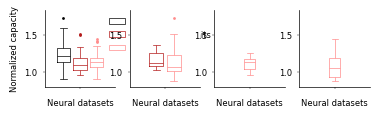

In [140]:
GAP = 0.2
MARKERSIZE = 2
YLIM = [0.8, 1.85]
colors = [
    "k",  # True
    [0.7, 0.1, 0.1],  # "Well detected" (strong red)
    [1, 0.55, 0.55],  # "single and multi-units" (pink)
]

fig, axes = plt.subplots(1, 4, figsize=(4.2, 1))

# KS 3.0 --------------------

plot_data = pd.DataFrame()
plot_data["Truth"] = (
    out_true["true_units"][0]["metrics_per_class"]["capacity"]
    / out_true["true_units"][1]["metrics_per_class"]["capacity"]
)
plot_data["Sorted single units"] = (
    out_ks3["sorted_single_unit"][0]["metrics_per_class"]["capacity"]
    / out_ks3["sorted_single_unit"][1]["metrics_per_class"]["capacity"]
)
plot_data["All sorted units"] = (
    out_ks3["all_sorted_units"][0]["metrics_per_class"]["capacity"]
    / out_ks3["all_sorted_units"][1]["metrics_per_class"]["capacity"]
)
plot_data = plot_data.melt()

# plot
ax = sns.boxplot(
    ax=axes[0],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors,
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.7,
)
axes[0].spines[["top", "right"]].set_visible(False)
axes[0].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[0].set_ylabel("Normalized capacity")
axes[0].set_xlabel("Neural datasets")
axes[0].set_ylim(YLIM)

# KS 2.5 --------------------

plot_data = pd.DataFrame()
plot_data["Sorted single units"] = (
    out_ks2_5["sorted_single_unit"][0]["metrics_per_class"]["capacity"]
    / out_ks2_5["sorted_single_unit"][1]["metrics_per_class"]["capacity"]
)
plot_data["All sorted units"] = (
    out_ks2_5["all_sorted_units"][0]["metrics_per_class"]["capacity"]
    / out_ks2_5["all_sorted_units"][1]["metrics_per_class"]["capacity"]
)
plot_data = plot_data.melt()

# plot
ax = sns.boxplot(
    ax=axes[1],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[1:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.5,
)
# axes[1].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[1].get_legend().remove()
axes[1].spines[["top", "right"]].set_visible(False)
axes[1].set_ylabel("")
axes[1].set_xlabel("Neural datasets")
axes[1].set_ylim(YLIM)

# HS  --------------------

plot_data = pd.DataFrame()
plot_data["All sorted units"] = (
    out_hs["all_sorted_units"][0]["metrics_per_class"]["capacity"]
    / out_hs["all_sorted_units"][1]["metrics_per_class"]["capacity"]
)
plot_data = plot_data.melt()

# plot
ax = sns.boxplot(
    ax=axes[2],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[2:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.2,
)
# axes[2].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[2].get_legend().remove()
axes[2].spines[["top", "right"]].set_visible(False)
axes[2].set_ylabel("")
axes[2].set_xlabel("Neural datasets")
axes[2].set_ylim(YLIM)

# KS  --------------------

plot_data = pd.DataFrame()
plot_data["All sorted units"] = (
    out_ks["all_sorted_units"][0]["metrics_per_class"]["capacity"]
    / out_ks["all_sorted_units"][1]["metrics_per_class"]["capacity"]
)
plot_data = plot_data.melt()

# plot
ax = sns.boxplot(
    ax=axes[3],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[2:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.2,
)
# axes[2].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[3].get_legend().remove()
axes[3].spines[["top", "right"]].set_visible(False)
axes[3].set_ylabel("")
axes[3].set_xlabel("Neural datasets")
axes[3].set_ylim(YLIM)

# fig.subplots_adjust(wspace=0.8, hspace=0.1)

plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/4_neural_code/svg/manifold_capacities.svg",
    **savefig_cfg,
)

#### Radius

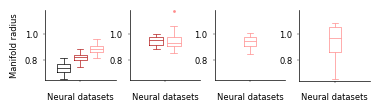

In [139]:
GAP = 0.2
MARKERSIZE = 2
YLIM = [0.65, 1.18]
fig, axes = plt.subplots(1, 4, figsize=(4.2, 1))

# KS 3.0 --------------------

plot_data = pd.DataFrame()
plot_data["Truth"] = out_true["true_units"][0]["metrics_per_class"]["radius"]
plot_data["Sorted single units"] = out_ks3["sorted_single_unit"][0][
    "metrics_per_class"
]["radius"]
plot_data["All sorted units"] = out_ks3["all_sorted_units"][0]["metrics_per_class"][
    "radius"
]
plot_data = plot_data.melt()


ax = sns.boxplot(
    ax=axes[0],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors,
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.7,
)
axes[0].set_box_aspect(1)
axes[0].spines[["top", "right"]].set_visible(False)
axes[0].get_legend().remove()
# axes[0].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[0].set_ylabel("Manifold radius")
axes[0].set_xlabel("Neural datasets")
axes[0].set_ylim(YLIM)

# KS 2.5 --------------------

plot_data = pd.DataFrame()
plot_data["Sorted single units"] = (
    out_ks2_5["sorted_single_unit"][0]["metrics_per_class"]["radius"]
    / out_ks2_5["sorted_single_unit"][1]["metrics_per_class"]["radius"]
)
plot_data["All sorted units"] = (
    out_ks2_5["all_sorted_units"][0]["metrics_per_class"]["radius"]
    / out_ks2_5["all_sorted_units"][1]["metrics_per_class"]["radius"]
)
plot_data = plot_data.melt()

ax = sns.boxplot(
    ax=axes[1],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[1:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.5,
)
axes[1].set_box_aspect(1)
axes[1].get_legend().remove()
# axes[1].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[1].spines[["top", "right"]].set_visible(False)
axes[1].set_xlabel("Neural datasets")
axes[1].set_ylim(YLIM)
axes[1].set_ylabel("")

# HS --------------------

plot_data = pd.DataFrame()
plot_data["All sorted units"] = (
    out_hs["all_sorted_units"][0]["metrics_per_class"]["radius"]
    / out_hs["all_sorted_units"][1]["metrics_per_class"]["radius"]
)
plot_data = plot_data.melt()

ax = sns.boxplot(
    ax=axes[2],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[2:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.2,
)
axes[2].set_box_aspect(1)
# axes[2].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[2].get_legend().remove()
axes[2].spines[["top", "right"]].set_visible(False)
axes[2].set_xlabel("Neural datasets")
axes[2].set_ylim(YLIM)
axes[2].set_ylabel("")
# KS --------------------

plot_data = pd.DataFrame()
plot_data["All sorted units"] = (
    out_ks["all_sorted_units"][0]["metrics_per_class"]["radius"]
    / out_ks["all_sorted_units"][1]["metrics_per_class"]["radius"]
)
plot_data = plot_data.melt()

ax = sns.boxplot(
    ax=axes[3],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[2:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.2,
)
axes[3].set_box_aspect(1)
# axes[3].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[3].get_legend().remove()
axes[3].spines[["top", "right"]].set_visible(False)
axes[3].set_xlabel("Neural datasets")
axes[3].set_ylabel("")
axes[3].set_ylim(YLIM)

# fig.subplots_adjust(wspace=0.5, hspace=0.1)

plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/4_neural_code/svg/manifold_radii.svg",
    **savefig_cfg,
)

#### Dimension

We could normalize by min(M,N) the upper bound dimensionality but we already use Gaussian random projection to reduce and standardize 
the unit feature dimensionality of all response matrices to `N_new`.

In that case the upper bound dimensionality for all neural datasets is min(M=50, N=200) = 50, the number of sample per class.

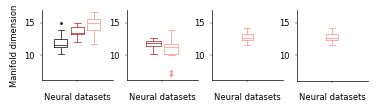

In [138]:
GAP = 0.2
MARKERSIZE = 2
METRICS = "dimension"
YLIM = [6, 17]
fig, axes = plt.subplots(1, 4, figsize=(4.2, 1))

# KS 3.0 --------------------

plot_data = pd.DataFrame()
plot_data["Truth"] = out_true["true_units"][0]["metrics_per_class"][METRICS]
plot_data["Sorted single units"] = out_ks3["sorted_single_unit"][0][
    "metrics_per_class"
][METRICS]
plot_data["All sorted units"] = out_ks3["all_sorted_units"][0]["metrics_per_class"][
    METRICS
]
plot_data = plot_data.melt()

# plot
ax = sns.boxplot(
    ax=axes[0],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors,
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.7,
)
axes[0].set_box_aspect(1)
axes[0].spines[["top", "right"]].set_visible(False)
axes[0].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[0].get_legend().remove()
axes[0].set_ylabel("Manifold dimension")
axes[0].set_xlabel("Neural datasets")
axes[0].set_ylim(YLIM)

# KS 2.5 --------------------

plot_data = pd.DataFrame()
plot_data["Sorted single units"] = out_ks2_5["sorted_single_unit"][0][
    "metrics_per_class"
][METRICS]
plot_data["All sorted units"] = out_ks2_5["all_sorted_units"][0]["metrics_per_class"][
    METRICS
]
plot_data = plot_data.melt()

# plot
ax = sns.boxplot(
    ax=axes[1],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[1:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.5,
)
axes[1].set_box_aspect(1)
# axes[1].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[1].get_legend().remove()
axes[1].spines[["top", "right"]].set_visible(False)
axes[1].set_ylabel("")
axes[1].set_xlabel("Neural datasets")
axes[1].set_ylim(YLIM)


# HS --------------------

plot_data = pd.DataFrame()
plot_data["All sorted units"] = out_hs["all_sorted_units"][0]["metrics_per_class"][
    METRICS
]
plot_data = plot_data.melt()

# plot
ax = sns.boxplot(
    ax=axes[2],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[2:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.2,
)
axes[2].set_box_aspect(1)
# axes[2].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[2].get_legend().remove()
axes[2].spines[["top", "right"]].set_visible(False)
axes[2].set_ylabel("")
axes[2].set_xlabel("Neural datasets")
axes[2].set_ylim(YLIM)

# KS --------------------

plot_data = pd.DataFrame()
plot_data["All sorted units"] = out_hs["all_sorted_units"][0]["metrics_per_class"][
    METRICS
]
plot_data = plot_data.melt()

# plot
ax = sns.boxplot(
    ax=axes[3],
    data=plot_data,
    hue="variable",
    y="value",
    fill=False,
    palette=colors[2:],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
    width=0.2,
)
axes[3].set_box_aspect(1)
# axes[3].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[3].get_legend().remove()
axes[3].spines[["top", "right"]].set_visible(False)
axes[3].set_ylabel("")
axes[3].set_xlabel("Neural datasets")
axes[3].set_ylim(YLIM)

# save fig
plt.savefig(
    PROJ_PATH + "/figures/4_neural_code/svg/manifold_dimension.svg",
    **savefig_cfg,
)

In [90]:
out_hs["all_sorted_units"][0]["metrics_per_class"][METRICS]

array([12.56739201, 13.23787268, 11.51501378, 13.93006519, 12.19485234,
       12.28160017, 12.46921641, 12.06494291, 11.77873262, 12.2317266 ,
       12.7777047 , 12.51607997, 12.96891564, 13.171467  , 13.15396575,
       13.31720464, 14.1200178 , 12.58799516, 12.30451754, 12.36281603])

#### Centroid correlation

2024-02-24 14:18:20,000 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[0.07061305111261482, 0.06949389406294815, 0.07005654961150318]
[0.07061305111261482, 0.07060403837503196, 0.07043657025634727]


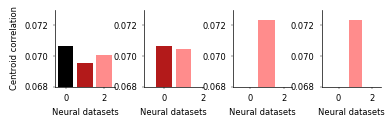

In [137]:
GAP = 0.2
MARKERSIZE = 2
METRICS = "correlation"
YLIM = [0.068, 0.073]
fig, axes = plt.subplots(1, 4, figsize=(4.2, 1))

# KS 3.0 --------------------

true_corr = out_true["true_units"][0]["metrics_per_class"][METRICS]
sorted_single_unit_corr_ks3 = out_ks3["sorted_single_unit"][0]["metrics_per_class"][
    METRICS
]
all_sorted_unit_corr_ks3 = out_ks3["all_sorted_units"][0]["metrics_per_class"][METRICS]

# plot
axes[0].bar(
    [0, 1, 2],
    [true_corr, sorted_single_unit_corr_ks3, all_sorted_unit_corr_ks3],
    color=colors,
)

# add legend
axes[0].spines[["top", "right"]].set_visible(False)
axes[0].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
axes[0].set_ylabel("Centroid correlation")
axes[0].set_xlabel("Neural datasets")
axes[0].set_ylim(YLIM)

# KS 2.5 --------------------

sorted_single_unit_corr_ks2_5 = out_ks2_5["sorted_single_unit"][0]["metrics_per_class"][
    METRICS
]
all_sorted_unit_corr_ks2_5 = out_ks2_5["all_sorted_units"][0]["metrics_per_class"][
    METRICS
]

# plot
axes[1].bar(
    [0, 1],
    [sorted_single_unit_corr_ks2_5, all_sorted_unit_corr_ks2_5],
    color=colors[1:],
    width=0.8,
)

# add legend
axes[1].spines[["top", "right"]].set_visible(False)
axes[1].set_ylabel("")
axes[1].set_xlabel("Neural datasets")
axes[1].set_ylim(YLIM)
axes[1].set_xlim([-1, 2])

# HS --------------------

all_sorted_unit_corr_hs = out_hs["all_sorted_units"][0]["metrics_per_class"][METRICS]

# plot
axes[2].bar([1], [all_sorted_unit_corr_hs], color=colors[2:], width=1)

# add legend
axes[2].spines[["top", "right"]].set_visible(False)
axes[2].set_ylabel("")
axes[2].set_xlabel("Neural datasets")
axes[2].set_ylim(YLIM)
axes[2].set_xlim([-1, 2.5])

# KS --------------------

all_sorted_unit_corr_ks = out_hs["all_sorted_units"][0]["metrics_per_class"][METRICS]

# plot
axes[3].bar([1], [all_sorted_unit_corr_ks], color=colors[2:])

# add legend
axes[3].spines[["top", "right"]].set_visible(False)
axes[3].set_ylabel("")
axes[3].set_xlabel("Neural datasets")
axes[3].set_ylim(YLIM)
axes[3].set_xlim([-1, 2.5])

fig.subplots_adjust(wspace=0.5, hspace=0.1)

plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/4_neural_code/svg/manifold_correlation.svg",
    **savefig_cfg,
)

print([true_corr, sorted_single_unit_corr_ks3, all_sorted_unit_corr_ks3])
print([true_corr, sorted_single_unit_corr_ks2_5, all_sorted_unit_corr_ks2_5])